# 03_BASELINES
**Date:** 06-10-2025

**Goals:** put the first baseline classifier and captioner models to work.

In [5]:
# imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
from classifying.data_loader import load_data
from pathlib import Path

from demo.app import PROJECT_ROOT, true_labels

try:
    PROJECT_ROOT = Path(__file__).resolve().parents[2]
except NameError:
    PROJECT_ROOT = Path.cwd().resolve().parent
DATA_PATH = PROJECT_ROOT / "data" / "labels"
labels_and_paths_csv_fp_sample = DATA_PATH / "labels_manifest_1000.csv"

labels_and_paths_csv_fp_full = PROJECT_ROOT / "data" / "processed" / "manifest_train_and_val.csv" # full labels filepath

full_dataset_present = False

manifest_fp = PROJECT_ROOT / "data" / "processed" / "manifest_train_and_val.csv"

np.random.seed(5629) # random seed for reproducibility
tf.random.set_seed(5629)

# 1. Classifier

Let's start with the classifier. For it, I am using a simple CNN sequential model from tensorflow.keras with a pretrained (ResNet50) head.

In [7]:
baseline_CNN_model = tf.keras.models.Sequential([ # baseline CNN model (input -> resnet50 -> convolution and max pooling layers -> dense layers with relu and softmax
    layers.InputLayer(shape=(224,224,3)),

    layers.RandomFlip(),
    layers.RandomRotation(1),
    layers.RandomTranslation(0.2, 0.2),

    tf.keras.applications.ResNet50(include_top=False,),

    layers.Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=2, strides=2, padding='same'),

    layers.Conv2D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=2, strides=2, padding='same'),

    layers.Conv2D(filters=256, kernel_size=3, strides=1, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, strides=1, activation='relu', padding='same'),
    layers.MaxPool2D(pool_size=2, strides=2, padding='same'),

    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(5 if full_dataset_present else 4, activation='softmax')
])

## Breakdown of the model:
- an input layer that takes the images' preprocessed data
- data augmentation layers (it is safe to use rotation and translation, as the position of the galaxy doesn't matter for classification, but crop, color change, etc. can skew the images)
- ResNet50 pre-trained head, made not trainable for our purposes
- multiple convolution + max pooling layers
- flatten the input to the dense layers
- finally, a few dense layers with relu activation + final layer: 5* output nodes (5 categories of galaxies), softmax activation.

_*only 4 categories in the sample (ambiguous not represented)._

Now, let's compile the model with categorical crossentropy loss to evaluate error among categories:

In [ ]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.001) # Adam optimizer as a superior for this task

baseline_CNN_model.compile( # compilation
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

It is time to load the data using data_loader.py and fit the model!

In [ ]:
train_sample, valid_sample = load_data(labels_and_paths_csv_fp_sample) # data loading (see data_loader.py)

history = baseline_CNN_model.fit( # fitting
    train_sample,
    validation_data=valid_sample,
    epochs=1
)

After a long time, the model finished fitting. To evaluate the results of the classifier, let's plot loss and accuracy graphs:

In [ ]:
hist = history.history

# plotting time!
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

![image.png](attachment:a04a98f5-1969-4d8f-84d6-bc12d8bfa160.png)

![image.png](attachment:ff6f2b4b-e590-4537-b950-f0b8d7caacef.png)

As can be seen, the training data accuracy shows steady growth. However, the validation curve is unstable and spiky near the end.

This means that the model is either overfitting or incorrectly interpreting the data with the pretrained head. Also, the augmentation may be too violent.

I softened the augmentation parameters and also froze the head to avoid overfitting + deleted convolution layers to reduce the amount of parameters and clutter overall. More importantly, I rewrote the classifier from Sequential() to a functional approach. And it worked!
The model really improved.

Old syntax:

    baseline_CNN_model = tf.keras.models.Sequential([ # baseline CNN model (input -> resnet50 -> convolution and max pooling layers -> dense layers with relu and softmax layer.
        InputLayer(input_shape=(224,224,3)), layers.RandomFlip(["horizontal", "vertical"]),

        layers.RandomRotation(0.2), layers.RandomTranslation(0.1, 0.1),

        layers.Lambda(tf.keras.applications.resnet50.preprocess_input, name="resnet_preproc"),
        tf.keras.applications.ResNet50(include_top=False, weights='imagenet', pooling='avg'),

        layers.Dense(128, activation='relu'), layers.Dropout(0.2),
        layers.Dense(5 if full_dataset_present else 4, activation='softmax')
    ])
    baseline_CNN_model.layers[5].trainable = False

New syntax:

In [ ]:
inputs = tf.keras.Input((224,224,3))
x = layers.RandomFlip(["horizontal", "vertical"])(inputs)
x = layers.RandomRotation(0.2)(x)
x = layers.RandomTranslation(0.1, 0.1)(x)
x = tf.keras.applications.resnet50.preprocess_input(x)

resnet = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", pooling="avg"
)
resnet.trainable = False
x = resnet(x, training=False)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5 if full_dataset_present else 4, activation="softmax")(x)
baseline_CNN_model = tf.keras.Model(inputs, outputs)

In [ ]:
from keras.src.callbacks import EarlyStopping

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # Adam optimizer as a superior for this task

baseline_CNN_model.compile( # compilation
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

train_sample, valid_sample = load_data(labels_and_paths_csv_fp_sample, "PC") # data loading (see data_loader.py)

history = baseline_CNN_model.fit( # fitting
    train_sample,
    validation_data=valid_sample,
    epochs=30,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
)

hist = history.history

# plotting time!
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Here are the new graphs:

![image.png](attachment:ef2526eb-a546-43e3-967a-5fb5423ef867.png)

![image.png](attachment:ecf68329-936e-46c7-90f6-85c4cf87f75d.png)

# Evaluation

The baseline classifier managed to get around **0.65** accuracy on the small sample dataset. As for the full dataset: 0.65 accuracy as well, but only on two epochs. My 4060 can only process one epoch per hour, so an enormous amount of time would be required to run 50 epochs.

Let's visualize a few examples with GradCAM. Unfortunately, given the model layout it was incredibly difficult to find the last conv layer, and I had to resort to AI to make the script.
The full code can be found in gradcam_visualizer_AI_gen.py

### Here are a few examples of heatmaps for some of the images:

![image.png](attachment:e77dace7-6674-49f2-b4b1-d2c571209c56.png)
![image.png](attachment:da511969-1bfe-4c05-8c36-6ef61457d65a.png)

Caption: galaxy in a merger, with a noticeable round bulge

![image.png](attachment:f647747a-6a74-462e-8c32-a25c02addf34.png) ![image.png](attachment:90c4463d-df42-42d8-a488-54d44e185596.png)

Caption: rounded/cigar-shaped edge-on spiral galaxy with a modest bulge

![image.png](attachment:dfc59b5b-e597-4321-bdab-37e886f8f82b.png) ![image.png](attachment:ff8c794d-9755-4fa7-853a-1b0affec38c7.png)

Caption: spiral galaxy with a central bar, with a ring structure, with a noticeable round bulge

![image.png](attachment:39bfa2a3-deb8-4fd4-b446-de913521040b.png) ![image.png](attachment:efa99303-57ee-4a66-9709-565e2e2771a1.png)

Caption: spiral galaxy with moderately wound spiral arms, with a central bar

The heat maps show that the classifier is working well, highlighting the galaxy and especially its core.

Edit: I rented a GPU on Runpod GPU cloud service to run the model on the full dataset for 50 epochs. Learning CLI commands and ssh was painful, but in the end I managed to get **0.66** accuracy (just .1 more than on two epochs). I'm not sure what led to such a poor increase in performance, maybe the fact that the latter was evaluated on the test set and the others were not. Here are the full metrics of the classifier, evaluated using classifying/final_test.py:

Accuracy: **0.6611570247933884**

Balanced accuracy: **0.4553593412688567**

F1 accuracy: **0.43673636975523233**

Weighted F1 accuracy: **0.6215608737286212**


### Detailed classification report:
|            | precision | recall | f1-score | support |
|------------|:---------:|:------:|:--------:|---------|
| ambiguous  |   0.47    |  0.05  |   0.09   | 3511    |
| edge-on    |   0.70    |  0.66  |   0.68   | 1612    |
| elliptical |   0.57    |  0.80  |   0.67   | 6873    |
| merger     |   0.00    |  0.00  |   0.00   | 67      |
| spiral     |   0.74    |  0.76  |   0.75   | 11895   |

|              | precision | recall | f1-score | support |
|--------------|:---------:|:------:|:--------:|---------|
| accuracy     |           |        |   0.66   | 23958   |
| macro avg    |   0.49    |  0.46  |   0.44   | 23958   |
| weighted avg |   0.64    |  0.66  |   0.62   | 23958   |


### Confusion matrix:

|            | spiral | elliptical | ambiguous | edge-on | merger |
|------------|:------:|:----------:|:---------:|:-------:|--------|
| spiral     |  171   |     51     |   1590    |    0    | 1699   |
| elliptical |   5    |    1066    |    164    |    0    | 377    |
| ambiguous  |   76   |    112     |   5521    |    0    | 1164   |
| edge-on    |   4    |     2      |    30     |    0    | 31     |
| merger     |  109   |    288     |   2416    |    0    | 9082   |

As can be seen, the highest accuracy was on spiral, which is no wonder, because this class is overrepresented in the dataset. Edge-on galaxies had a similar level of accuracy, as it is easy to distinguish from other galaxies. Recall for elliptical is high (0.8), but recall (0.57) suggests that a lot of false ellipticals were guessed. Ambiguous shows good precision (not many false positives), but this 'caution' led recall to plummet; the model only found 5% of all galaxies in this class. Merger barely appears in the dataset, hence a 0 result (that's basically a rudimentary class).

The confusion matrix reveals that the most difficult classes to discern were merger and ambiguous. Occasional mistakes in other classes happen, but they are insignificant. The main diagonal is not as bright as I would have hoped.

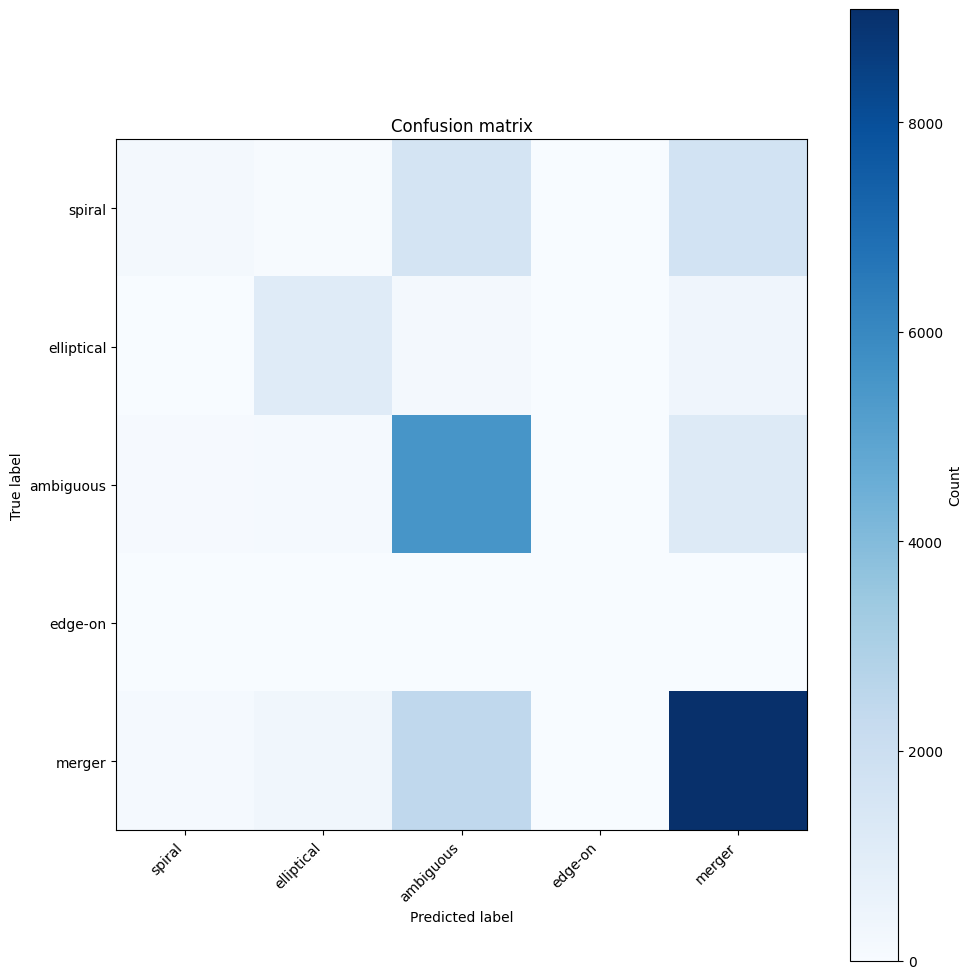

In [3]:

cm = np.array([
    [171, 51, 1590, 0, 1699],
    [5, 1066, 164, 0, 377],
    [76, 112, 5521, 0, 1164],
    [4, 2, 30, 0, 31],
    [109, 288, 2416, 0, 9082]]
)

fig, ax = plt.subplots(figsize=(10, 10))

classes = ["spiral", "elliptical", "ambiguous", "edge-on", "merger"]

plt.imshow(cm, interpolation="nearest", cmap='Blues')
plt.colorbar(label="Count")
plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
plt.yticks(range(len(classes)), classes)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.tight_layout()
plt.show()

# 2. Captioner

As for the captioner, I first need to create a description for each image in the dataset. But should I do it by hand? NO! It is impossible to describe more than 200 thousand images, typing by hand.

Instead, let's make use of the features from the dataset that we dropped earlier when building the classifier. If we extract the fractions of voters that selected particular features in a given image, we can add these features in text to the caption! Also, I add some deterministic randomness (selecting the (i % 2) item in a list) for variety.

Here is the caption generator code:

In [ ]:
import pandas as pd

df = pd.read_csv(manifest_fp)

features_column_names = {
    # General features
    "features": "t01_smooth_or_features_a02_features_or_disk_debiased",
    "smooth": "t01_smooth_or_features_a01_smooth_debiased",
    "spiral": "t04_spiral_a08_spiral_debiased",
    "no_spiral": "t04_spiral_a09_no_spiral_debiased",
    "edge_on": "t02_edgeon_a04_yes_debiased",
    "bar": "t03_bar_a06_bar_debiased",
    "rounded/cigar-shaped": "t07_rounded_a18_cigar_shaped_debiased",

    # Bulge features
    "no_bulge": "t05_bulge_prominence_a10_no_bulge_debiased",
    "bulge_just_noticeable": "t05_bulge_prominence_a11_just_noticeable_debiased",
    "bulge_obvious": "t05_bulge_prominence_a12_obvious_debiased",
    "bulge_dominant": "t05_bulge_prominence_a13_dominant_debiased",
    "bulge_rounded": "t09_bulge_shape_a25_rounded_debiased",
    "bulge_boxy": "t09_bulge_shape_a26_boxy_debiased",

    # Odd features
    "odd": "t06_odd_a14_yes_debiased",
    "ring": "t08_odd_feature_a19_ring_debiased",
    "lens_or_arc": "t08_odd_feature_a20_lens_or_arc_debiased",
    "disturbed": "t08_odd_feature_a21_disturbed_debiased",
    "irregular": "t08_odd_feature_a22_irregular_debiased",
    "other_odd": "t08_odd_feature_a23_other_debiased",
    "merger": "t08_odd_feature_a24_merger_debiased",
    "dust_lane": "t08_odd_feature_a38_dust_lane_debiased",

    # Arms winding features
    "winding_tight": "t10_arms_winding_a28_tight_debiased",
    "winding_medium": "t10_arms_winding_a29_medium_debiased",
    "winding_loose": "t10_arms_winding_a30_loose_debiased",

    # Number of arms
    "n_1": "t11_arms_number_a31_1_debiased",
    "n_2": "t11_arms_number_a32_2_debiased",
    "n_3": "t11_arms_number_a33_3_debiased",
    "n_4": "t11_arms_number_a34_4_debiased",
    "n_5+": "t11_arms_number_a36_more_than_4_debiased",
    "n_undefined": "t11_arms_number_a37_cant_tell_debiased",
}

def get_feature_value(row, feature_name):
    return row[feature_name]

captions = pd.DataFrame({"objid": [], "caption": []})

for i in range (df.shape[0]):
    caption = "galaxy"
    if df.iloc[i][features_column_names["irregular"]] >= 0.6:
        caption = "irregular " + caption
    elif df.iloc[i][features_column_names["spiral"]] >= 0.6 or df.iloc[i][features_column_names["features"]] >= df.iloc[i][features_column_names["smooth"]]:
        caption = "spiral " + caption
        if df.iloc[i][features_column_names["winding_tight"]] >= 0.6:
            caption += [" with tightly wound arms,", " with tightly wound spiral arms,"][i % 2]
        elif df.iloc[i][features_column_names["winding_medium"]] >= 0.6:
            caption += [" with moderately wound arms,", " with moderately wound spiral arms,"][i % 2]
        elif df.iloc[i][features_column_names["winding_loose"]] >= 0.6:
            caption += [" with loosely wound arms,", " with loosely wound spiral arms,"][i % 2]
        if df.iloc[i][features_column_names["n_1"]] >= 0.6:
            caption += [" with 1 spiral arm,", " with a single spiral arm,"][i % 2]
        elif df.iloc[i][features_column_names["n_2"]] >= 0.6:
            caption += [" with 2 spiral arms,", " with a pair of spiral arms,"][i % 2]
        elif df.iloc[i][features_column_names["n_3"]] >= 0.6:
            caption += [" with 3 spiral arms,", " with three spiral arms,"][i % 2]
        elif df.iloc[i][features_column_names["n_4"]] >= 0.6:
            caption += [" with 4 spiral arms,", " with four spiral arms,"][i % 2]
        elif df.iloc[i][features_column_names["n_5+"]] >= 0.6:
            caption += [" with more than 5 spiral arms,", " with many spiral arms,"][i % 2]
    elif df.iloc[i][features_column_names["smooth"]] >= 0.6 and df.iloc[i][features_column_names["smooth"]] >= df.iloc[i][features_column_names["features"]]:
        caption = "elliptical " + caption

    if df.iloc[i][features_column_names["merger"]] >= 0.6:
        if i % 2 == 0: caption = "interacting/merging " + caption
        else: caption += " in a merger,"
    if df.iloc[i][features_column_names["edge_on"]] >= 0.6:
        if i % 2 == 0: caption = "edge-on " + caption
        else: caption += " seen edge-on,"
    if df.iloc[i][features_column_names["bar"]] >= 0.6:
        if i % 2 == 0: caption = "barred " + caption
        else: caption += " with a central bar,"
    if df.iloc[i][features_column_names["rounded/cigar-shaped"]] >= 0.6:
        caption = "rounded/cigar-shaped " + caption

    if df.iloc[i][features_column_names["ring"]] >= 0.6:
        caption += [" with a ring,", " with a ring structure,"][i % 2]
    if df.iloc[i][features_column_names["dust_lane"]] >= 0.6:
        caption += [" with a dust lane,", " with dust lanes,"][i % 2]
    if df.iloc[i][features_column_names["disturbed"]] >= 0.6 and "interacting/merging" not in caption:
        caption += [" with disturbed morphology,", " with signs of disturbance,"][i % 2]
    if df.iloc[i][features_column_names["lens_or_arc"]] >= 0.6 and "elliptical" in caption:
        caption += " with a lens/arc feature,"

    if df.iloc[i][features_column_names["no_bulge"]] >= 0.6:
        caption += [" with a small or non-existent", " with a faint or not prominent"][i % 2]
        if df.iloc[i][features_column_names["bulge_rounded"]] >= 0.6:
            caption += [" with a rounded bulge,", " with a round bulge,"][i % 2]
        elif df.iloc[i][features_column_names["bulge_boxy"]] >= 0.6:
            caption += [" with a boxy bulge,", " with a rectangular/boxy bulge,"][i % 2]
        else:
            caption += " bulge,"
    elif df.iloc[i][features_column_names["bulge_just_noticeable"]] >= 0.6:
        caption += [" with a modest", " with a noticeable"][i % 2]
        if df.iloc[i][features_column_names["bulge_rounded"]] >= 0.6:
            caption += [" with a rounded bulge,", " with a round bulge,"][i % 2]
        elif df.iloc[i][features_column_names["bulge_boxy"]] >= 0.6:
            caption += [" with a boxy bulge,", " with a rectangular/boxy bulge,"][i % 2]
        else:
            caption += " bulge,"
    elif df.iloc[i][features_column_names["bulge_obvious"]] >= 0.6:
        caption += [" with a prominent", " with a conspicuous"][i % 2]
        if df.iloc[i][features_column_names["bulge_rounded"]] >= 0.6:
            caption += [" with a rounded bulge,", " with a round bulge,"][i % 2]
        elif df.iloc[i][features_column_names["bulge_boxy"]] >= 0.6:
            caption += [" with a boxy bulge,", " with a rectangular/boxy bulge,"][i % 2]
        else:
            caption += " bulge,"
    elif df.iloc[i][features_column_names["bulge_dominant"]] >= 0.6:
        caption += [" with a dominant", " with a very large"][i % 2]
        if df.iloc[i][features_column_names["bulge_rounded"]] >= 0.6:
            caption += [" with a rounded bulge,", " with a round bulge,"][i % 2]
        elif df.iloc[i][features_column_names["bulge_boxy"]] >= 0.6:
            caption += [" with a boxy bulge,", " with a rectangular/boxy bulge,"][i % 2]
        else:
            caption += " bulge,"

    if caption[-1] == ',': caption = caption[:-1]

    captions.loc[len(captions)] = [df.iloc[i]["objid"], caption]

out = captions

#out.to_csv(str(PROJECT_ROOT / "data" / "processed" / "captions_full.csv"), index=False, encoding="utf-8") # Save the caption (no need to now)

## A few examples of generations:

![image.png](attachment:87092e6a-0060-4686-94f5-d4c0f27055f3.png)

**Caption:** "spiral galaxy with tightly wound spiral arms, with four spiral arms, with a noticeable bulge"

![image.png](attachment:84944b21-3695-426a-a5c3-93f1ad4da400.png)

**Caption:** "rounded/cigar-shaped spiral galaxy with a pair of spiral arms, seen edge-on, with a ring structure, with a noticeable round bulge"

![image.png](attachment:54f648cd-b2e6-451e-b579-c3120dc9f9af.png)

**Caption:** "rounded/cigar-shaped spiral galaxy with tightly wound spiral arms, with a pair of spiral arms, in a merger"

![image.png](attachment:a3f58bf5-f512-48ae-81d6-d8bafbdee1c6.png)

**Caption:** "barred irregular galaxy with a small or non-existent bulge"


#### Now, it's time to build a model that would generate captions from an image directly.

First, we need to tokenize the input caption, i.e. assign an id to every word. Also, we must add special tokens:
- **< bos >** - indicator of the beginning of a sentence
- **< eos >** - indicator of the end of a sentence
- **< pad >** - padding token, we'll use it to extend shorter captions to the same fixed length.
- **< unk >** - unknown token

We then will infer the vocabulary from the training dataset.

In [ ]:
import json
from collections import Counter

# Initialize special tokens
special_tokens = {"<bos>", "<eos>", "<pad>", "<unk>"}

#Path struggles
all_captions_path = DATA_PATH / "captions" / "captions_sample.csv"
caption_train_path = DATA_PATH / "captions" / "train_captions_sample.txt"
df = pd.read_csv(all_captions_path, dtype={"objid": str})
train_ids = pd.read_csv(
    caption_train_path,
    header=None,
    names=["objid"],
    dtype=str,
    sep=r"\s+",
    engine="python",
)
df_train = df.merge(train_ids, how="inner", on="objid").reset_index(drop=True)

captions = df_train["caption"].astype(str).tolist()

#Token inference
tokens = []
for caption in captions:
    caption = caption.lower().replace(",", "")
    tokens.extend([d for d in caption.split(" ")])
# Order the words by frequency
freq = [token for token, _ in Counter(tokens).most_common()]

inferred_vocab = [g for g in freq]
inferred_vocab = ["<pad>", "<bos>", "<eos>", "<unk>"] + inferred_vocab
# Save the inferred vocabulary for later in a json file
vocab_path = DATA_PATH / "vocab.json"
json.dump(inferred_vocab, open(vocab_path, "w"))

config = {"pad_id" : 0, "bos_id" : 1, "eos_id" : 2, "unk_id" : 3, "max_len" : 24}
config_path = DATA_PATH / "config.json"
# Save basic info on captions in another .json file
json.dump(config, open(config_path, "w"))
# Transformation functions not to get lost
id2token = inferred_vocab
token2id = {token: inferred_vocab.index(token) for token in inferred_vocab}

Now I add some utility functions for later, so encoding/decoding a caption from language to numbers becomes easy.

In [ ]:
#Token encoder/decoder
def encode(text):
    # Strip punctuation
    text = text.lower().replace(",", "")
    ids_list = [token2id.get(token, 3) for token in text.split()][:config["max_len"] - 2]

    # Make two lists: cap_in and cap_out, cap_out being shifted by one word relative to cap_in (for teacher forcing)
    cap_in = [1] + ids_list
    cap_out = ids_list + [2]
    cap_in = cap_in + [0] * (config["max_len"] - len(cap_in))
    cap_out = cap_out + [0] * (config["max_len"] - len(cap_out))

    # Add a mask so <pad> tokens get ignored
    pad_mask = [1] * (len(ids_list) + 1) + [0] * (config["max_len"] - len(ids_list) - 1)

    return cap_in, cap_out, pad_mask

def decode(id_list):
    # Straightforward translation using the id2token list
    tokens = []
    for i in id_list:
        token = id2token[i] if 0 <= i < len(id2token) else "<unk>"
        if token == "<eos>":
            break
        if token in ["<pad>", "<bos>", "<eos>"]:
            continue
        tokens.append(token)
    caption_out = " ".join(tokens)
    return caption_out

I saved the two previous cells to tokenizer.py. Just as with the training dataset loader, we need to build a new one for the captioner. We can reuse some of the code from the aforementioned loader and keep the structure, but instead of a label list we will have caption lists. Here it is:

In [ ]:
all_captions_path = DATA_PATH / "captions" / "captions_sample.csv"
caption_train_path = DATA_PATH / "captions" /"train_captions_sample.txt"
caption_valid_path = DATA_PATH / "captions" /"val_captions_sample.txt"

config_fp = DATA_PATH / "captions" / "config.json"

config = json.load(open(config_fp))

def dataset():
    manifest = pd.read_csv(all_captions_path, dtype={"objid": str})
    train_ids = pd.read_csv(
        caption_train_path,
        header=None,
        names=["objid"],
        dtype=str,
        sep=r"\s+",
        engine="python",
    )
    valid_ids = pd.read_csv(
        caption_valid_path,
        header=None,
        names=["objid"],
        dtype=str,
        sep=r"\s+",
        engine="python",
    )
    df_train = manifest.merge(train_ids, on=["objid"], how="inner")
    df_valid = manifest.merge(valid_ids, on=["objid"], how="inner")

    # lambda functions flex
    train_paths_list = df_train["filepath"].astype(str).apply(lambda x: str(PROJECT_ROOT / x)).tolist()
    train_captions_list = df_train["caption"].astype(str).tolist()
    valid_paths_list = df_valid["filepath"].astype(str).apply(lambda x: str(PROJECT_ROOT / x)).tolist()
    valid_captions_list = df_valid["caption"].astype(str).tolist()

    train_captions_in = []
    train_captions_out = []
    train_captions_masks = []

    # Encode the captions one-by-one
    for cap in train_captions_list:
        cap_in, cap_out, msk = encode(cap)
        train_captions_in.append(cap_in)
        train_captions_out.append(cap_out)
        train_captions_masks.append(msk)

    train_captions_in = np.array(train_captions_in, dtype="int32")
    train_captions_out = np.array(train_captions_out, dtype="int32")
    train_captions_masks = np.array(train_captions_masks, dtype="float32")

    valid_captions_in = []
    valid_captions_out = []
    valid_captions_masks = []

    # Same for valid
    for cap in valid_captions_list:
        cap_in, cap_out, msk = encode(cap)
        valid_captions_in.append(cap_in)
        valid_captions_out.append(cap_out)
        valid_captions_masks.append(msk)

    valid_captions_in = np.array(valid_captions_in, dtype="int32")
    valid_captions_out = np.array(valid_captions_out, dtype="int32")
    valid_captions_masks = np.array(valid_captions_masks, dtype="float32")

    # Image preprocess function (unchanged)
    def PREPROCESS(path, cap_in, cap_out, mask):
        image = tf.io.read_file(path)
        image = tf.image.decode_image(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(image, [224, 224])
        image = tf.cast(image, tf.float32)
        image.set_shape((224, 224, 3))

        tf.ensure_shape(cap_in, (config['max_len'],))
        tf.ensure_shape(cap_out, (config['max_len'],))
        tf.ensure_shape(mask, (config['max_len'],))

        return image, cap_in, cap_out, mask

    # Same as in the captioner
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = tf.data.Dataset.from_tensor_slices((train_paths_list,
                                                   train_captions_in, train_captions_out,
                                                   train_captions_masks))
    train_ds = (
        train_ds.shuffle(buffer_size=len(train_paths_list), seed=37)
        .map(PREPROCESS, num_parallel_calls=AUTOTUNE)
        .map(lambda image, cap_in, cap_out, mask: ((image, cap_in), cap_out, mask))
        .batch(32)
        .prefetch(AUTOTUNE)
    )

    valid_ds = tf.data.Dataset.from_tensor_slices((valid_paths_list,
                                                   valid_captions_in, valid_captions_out,
                                                   valid_captions_masks))
    valid_ds = (
        valid_ds
        .map(PREPROCESS, num_parallel_calls=AUTOTUNE)
        .map(lambda image, cap_in, cap_out, mask: ((image, cap_in), cap_out, mask))
        .batch(32)
        .prefetch(AUTOTUNE)
    )

    return train_ds, valid_ds


Saved that to build_dataset.py. Now let's build the model itself. I decided to use an LSTM from tensorflow as it is a robust and tested non-transformer approach to NLP. First, the encoder.

In [ ]:
# Prerequisites
vocab_fp = DATA_PATH / "captions" / "vocab.json"
resnet_weights_fp = PROJECT_ROOT / "checkpoints" / "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
config = json.load(open(config_fp))
vocab = json.load(open(vocab_fp))
vocab_size = len(vocab)

# Encoder
inputs = tf.keras.Input((224,224,3)) # Input

x = layers.RandomFlip(["horizontal", "vertical"])(inputs) # Augmentation because why not
x = layers.RandomRotation(0.2)(x)
x = layers.RandomTranslation(0.1, 0.1)(x)
x = tf.keras.applications.resnet50.preprocess_input(x)

resnet = tf.keras.applications.ResNet50( # Base ResNet50
    include_top=False, weights=resnet_weights_fp, pooling="avg"
)
resnet.trainable = False
x = resnet(x, training=False)
img_emb = layers.Dense(256, activation="relu")(x)

h0 = layers.Dense(units=256, activation='tanh')(img_emb) # Initial hidden state
c0 = layers.Dense(units=256, activation='tanh')(img_emb)# Initial cell state

Here goes the decoder.

In [ ]:
# Decoder
token_input = layers.Input((config['max_len'],), dtype='int32')

token_embedding = layers.Embedding(vocab_size, 256, mask_zero=True)(token_input) # Embedding layer
LSTM_out = layers.LSTM(256, return_sequences=True)(token_embedding, initial_state=[h0, c0]) # Main LSTM layer
dropped = layers.Dropout(0.3)(LSTM_out) # A little dropout
logits = layers.TimeDistributed(layers.Dense(vocab_size))(dropped) # Temporal slicing layer added to mitigate a bug


captioner_model = tf.keras.Model(inputs=[inputs, token_input], outputs=logits) # Final model (inputs: preprocessed image&tokens, outputs: logits to later infer from)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

captioner_model.compile( # Compilation
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Finally, the fit function and plotting.

In [ ]:
train_ds, valid_ds = dataset()

history = captioner_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=50,
)
hist = history.history

#captioner_model.save(PROJECT_ROOT / "checkpoints" / "captioner_model.keras")

#Plotting time!
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


The graphs show improvement of prediction over time, validating the correctness of the previous steps.

Let's add an infer function:

In [ ]:
captioner_weights_fp = PROJECT_ROOT / "checkpoints" / "captioner_model.keras"

def generate_caption(image_fp):
    config = json.load(open(config_fp))
    vocab = json.load(open(vocab_fp))

    inferred_captioner = tf.keras.models.load_model(captioner_weights_fp)

    # Same old preprocessing
    image = tf.io.read_file(str(image_fp))
    image = tf.image.decode_image(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image.set_shape((224, 224, 3))
    image = tf.expand_dims(image, 0)

    #Start sequence
    seq = np.full((1, config["max_len"]), config["pad_id"], dtype=np.int32)
    seq[0, 0] = config["bos_id"]

    for i in range(config["max_len"] - 1):
        # Infer the next token
        seq_as_a_tensor = tf.convert_to_tensor(seq, dtype=tf.int32)
        output_logits = inferred_captioner([image, seq_as_a_tensor], training=False) # Probabilities of each word => pick highest
        token_id = int(np.argmax(output_logits[0, i, :])) # Messing with datatypes
        seq[0, i + 1] = token_id
        if token_id == config["eos_id"]: break

    tokens = [vocab[i] for i in seq[0, :]]
    caption = " ".join(tokens)

    return caption.replace("<bos>", "").replace("<eos>", "").replace("<pad>", "").replace("a a ", "a ").strip()


All the captioner code is nested inside src/captioning.

Let's see how the model works on images it had never seen before.

### Some examples of generations:

![image.png](attachment:d2bf524e-81b5-4ebd-bc1e-3bbe8ce9da49.png)
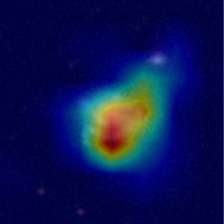

Caption: **spiral** galaxy with a ring with a ring structure

Note: redundant ring feature statement

![image.png](attachment:ec6d9a43-057d-424b-bc25-3a258f0b168c.png)
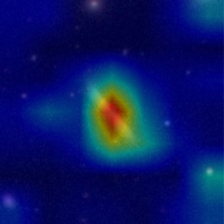

Caption: rounded/cigar-shaped **edge-on** spiral galaxy with a modest rounded bulge

Note: correct edge-on feature, but I feel like "rounded/cigar-shaped" is predicted almost every second time.

![image.png](attachment:0b1bc6c1-5f13-473b-a3e6-99124efcb1d9.png)
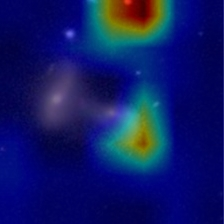

Caption: **interacting/merging** spiral galaxy with a prominent rounded bulge

Note: correct identification of merging, however, the caption redundantly included "spiral".

![image.png](attachment:3ab344d1-45d7-495b-a1ae-8a16ae6665b4.png)
![image.png](attachment:c20fd4b5-3955-47fd-a0da-50adaab7a28b.png)

Caption: interacting/merging spiral galaxy with a prominent bulge

Note: the galaxy clearly isn't spiral nor merger, an example of a way-off generation.

## Quality assessment and scores

Positive observations:

* The captioner writes real captions and not nonsense like "the the the the". This means that the training reward system was working and steering the model to predict language structures close to the ones in the templates.

* The captions often reflect, although with mistakes, the core morphological structure of the galaxy presented.

* The average length of the caption is appropriate

Negative traits:

* **Variety issues.** The captions are very template-like, always predicting the 'safest' option. "rounded/cigar-shaped" and "with a bulge" seem to be predicted almost every time. This may be due to a small training set, but also due to class imbalance. Spiral galaxies dominate the dataset, hence the "spiral" prediction is in every 3 out of 4 generations. Another reason might be the post-training greedy search in inference, which is always picking the most likely word, likely leading to lifeless captions.

* **Mistakes.** The model tried learning features, but it either struggled to find the features on the small amount of examples (to be fair, most images are very similar in their boringness) or learned other, self-inferred features that helped find flaws in the reward system. For example, analyzing the grad-cam I noticed an unhealthy interest of the model in background objects: stars and other galaxies.

### BLEU scores:
BLEU-1 score: 0.4741804229326942

BLEU-2 score: 0.37890422259968565

BLEU-3 score: 0.2785893807736973

BLEU-4 score: 0.1869921196830256

The score is decent as a baseline, considering the state of the dataset and the simplicity of the model. Perhaps changing inference strategy or improving original caption richness will help to achieve better results.